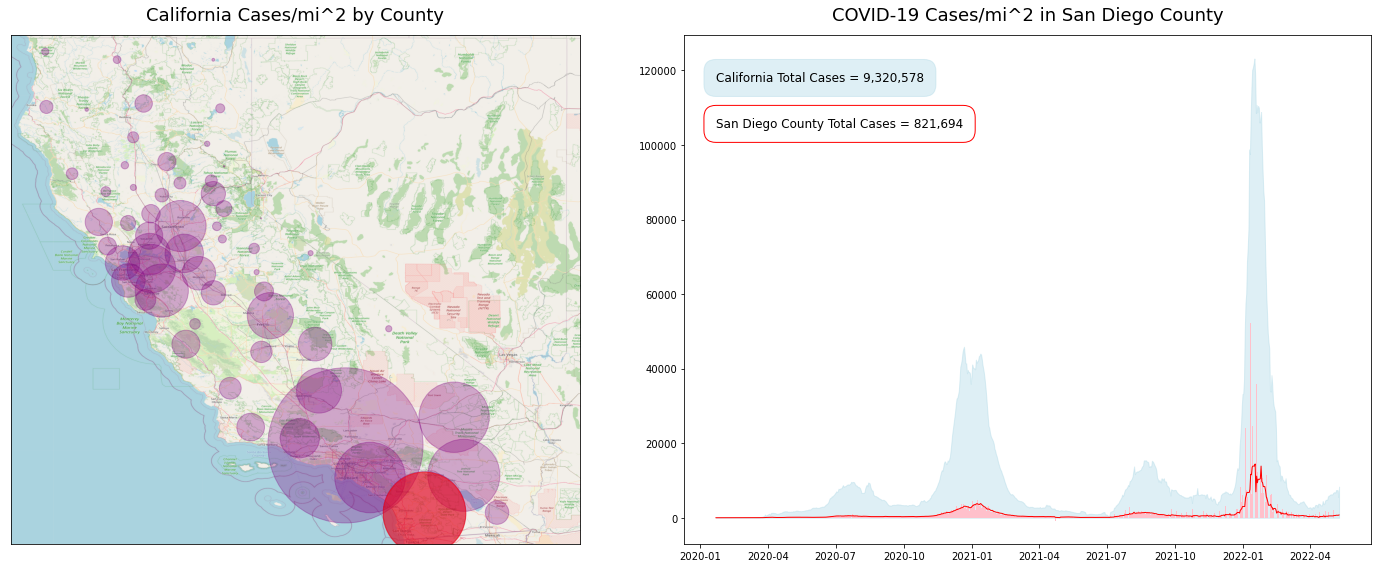

In [1]:
'''
Note: this project was meant to be run using Command Line Arguments. For the sake of this notebook,
we will consider the command line input as 'cases "San Diego"'

'''

argv = ["COVID_Visualization.py","cases", "San Diego"]  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime


def right_input(string):
    good_input = ["death", "deaths", "Deaths",
                  "Death", "case", "cases", "Cases", "Case"]
    if string in good_input:
        return True
    else:
        return False


def case_or_death(string):
    # not sure if there was a more compact way to do this...
    if right_input(string):
        if string == "death" or string == "deaths" or string == "Deaths" or string == "Death":
            return ("Deaths")
        elif string == "case" or string == "cases" or string == "Cases" or string == "Case":
            return ("Cases")


def error_message():
    print("----")
    print("--------")
    print("Incorrect input: <deaths/cases> <County>")
    print("--------")
    print("----")


  
    
if right_input(argv[1]):
    title_type = case_or_death(argv[1])
else:
    error_message()


# two-word county must be in quotes (i.e. "Los Angeles")
county = argv[2]


if title_type == "Cases":
    covid_file = "time_series_covid19_confirmed_US.csv"
elif title_type == "Deaths":
    covid_file = "time_series_covid19_deaths_US.csv"


covid_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/"

covid = pd.read_csv(covid_url + covid_file, delimiter=",")

covid = covid.rename(columns={"Admin2": "County", "Province_State": "State"})
covid = covid[covid["State"] == "California"]
covid = covid.set_index("County")

unused_columns = ["UID", "iso2", "iso3", "code3",
                  "FIPS", "Long_", "Lat", "Country_Region", "Combined_Key", "State"]
covid = covid.drop(columns=unused_columns)

if title_type == "Deaths":         # the "cases" file doesn't have this column
    covid = covid.drop(columns=["Population"])


last_col = covid.shape[1]-1
covid["Total Deaths"] = covid.iloc[:, last_col]
# this is while days are still cumulative, total deaths is a copy of the last day
# in case files, this could be thought of as "total cases"


last_col = covid.shape[1]-2
for col in range(last_col, 0, -1):
    covid.iloc[:, col] = covid.iloc[:, col] - covid.iloc[:, col-1]
# conversion from cumulative to daily


stats = pd.read_csv("california_county_stats.txt", delimiter=",")
stats = stats.set_index('County')
stats["Population Density"] = round(stats['Population'] / stats['Area'], 1)

df = pd.merge(stats, covid, left_index=True, right_index=True)

last_col = covid.shape[1]
last_row = covid.shape[0] - 1
covid.loc["Totals"] = 0

for col in range(last_col):
    covid.loc['Totals'][col] = covid.iloc[:, col].sum(axis=0)


totals = covid.drop(columns=['Total Deaths'])

df2 = covid.drop(columns=['Total Deaths'])

for pos in range(7):  # first six day averages
    df2.iloc[:, pos] = covid.iloc[:, :pos].sum(axis=1)
    df2.iloc[:, pos] = df2.iloc[:, pos]/(pos+1)
    df2.iloc[:, pos] = round(df2.iloc[:, pos], 1)


last_col = covid.shape[1] - 1    # other rolling averages
for pos in range(7, last_col):
    df2.iloc[:, pos] = covid.iloc[:, (pos-6):(pos+1)].sum(axis=1)
    df2.iloc[:, pos] = df2.iloc[:, pos] / 7
    df2.iloc[:, pos] = round(df2.iloc[:, pos], 1)


california = mpimg.imread('california.png')

x_coords = df.iloc[:, 1]
y_coords = df.iloc[:, 0]


dot_size = []
multiplier = 0
mean = 0

for i in range(df.shape[0]):
    mean += df['Population Density'][i]
    mean = mean / df.shape[0]

if title_type == "Deaths":
    multiplier = round(10 ** (mean) / 500, 5)
else:
    multiplier = round(10 ** (mean) / 20000,  5)

for i in range(df.shape[0]):
    # total deaths is like total cases when in Case file
    dot_size.append(df['Total Deaths'][i] * multiplier)


fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(20, 8))

# California map scatterplot

axis1.scatter(x_coords, y_coords, alpha=0.3, s=dot_size, color="purple")
axis1.scatter(df.loc[county][1], df.loc[county][0], alpha=0.5,
              s=dot_size[df.index.get_loc(county)], color='red')

axis1.imshow(california, extent=[-124.55, -113.80, 32.45, 42.05])

axis1.set_title(
    "California {}/mi^2 by County".format(title_type), fontsize=18, pad=15)

axis1.set_xticks([])
axis1.set_yticks([])

# California total rolling average

y_vals = df2.loc['Totals']
x_vals = df2.loc['Totals'].index
x_vals = [datetime.strptime(day, '%m/%d/%y') for day in x_vals]

y_pos = max(y_vals)
ran = max(y_vals) - min(y_vals)

y_pos = y_pos - (ran * 0.05)

cal_total = covid.iloc[covid.shape[0]-1, covid.shape[1]-1]

axis2.text(x_vals[0], y_pos, "California Total {} = {:,}".format(title_type, cal_total), fontsize=12,
           bbox=dict(facecolor='lightblue', edgecolor='lightblue', boxstyle='round,pad=1', alpha=0.4))


axis2.yaxis.grid()
axis2.plot(x_vals, y_vals, "-", color="lightblue", alpha=0)
axis2.fill_between(x_vals, y_vals, color='lightblue', alpha=0.4)

# county total deaths

y2_pos = max(y_vals) - (ran * 0.15)

cty_total = covid.loc[county][covid.shape[1]-1]

axis2.text(x_vals[0], y2_pos, "{} County Total {} = {:,}".format(county, title_type, cty_total),
           fontsize=12, bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=1'))

x_cords = totals.loc[county].index
x_cords = [datetime.strptime(day, '%m/%d/%y') for day in x_cords]

y_cords = totals.loc[county]
axis2.bar(x_cords, y_cords, width=1, color='pink', linewidth=0)


# county rolling average line chart

y_vals = df2.loc[county]
x_vals = df2.loc[county].index
x_vals = [datetime.strptime(day, '%m/%d/%y') for day in x_vals]

axis2.yaxis.grid()
axis2.plot(x_vals, y_vals, "-", color="red", linewidth=1)
axis2.set_title(
    "COVID-19 {}/mi^2 in {} County".format(title_type, county), fontsize=18, pad=15)

plt.tight_layout()
plt.show()
